# 평균모멘텀스코어 채권 혼합 그림 2-31
- 투자 기간 : 2003년 6월 ~2017년 6월
- 투자 대상 : S&P500 지수(SPY), 미국 10년 만기 국채(IEF), 20년 만기 국채(TLT)
- 매수 규칙 : 주식 :채권 = S&P500지수 최근 12개월 평균 모멘텀 스코어:10년(또는 20년) 만기 국고채 지수 최근 12개월 평균 모멘텀 스코어 
- 매도 규칙 : 매달 말 위의 투자 비중을 새로 계산하여 주식 :채권 투자 비중을 조절하여 반복

2-32 변동성역가중 전략과 비교

In [1]:
from settings import *

In [2]:
tickers = ['SPY', 'IEF', 'TLT']
read_df = yf.download(tickers)['Adj Close']
read_df.info()

[*********************100%***********************]  3 of 3 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7309 entries, 1993-01-29 to 2022-02-04
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IEF     4916 non-null   float64
 1   SPY     7309 non-null   float64
 2   TLT     4916 non-null   float64
dtypes: float64(3)
memory usage: 228.4 KB


In [3]:
read_df = read_df.dropna()
read_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4916 entries, 2002-07-30 to 2022-02-04
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IEF     4916 non-null   float64
 1   SPY     4916 non-null   float64
 2   TLT     4916 non-null   float64
dtypes: float64(3)
memory usage: 153.6 KB


In [4]:
data = read_df[:'2017-6'].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3758 entries, 2002-07-30 to 2017-06-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IEF     3758 non-null   float64
 1   SPY     3758 non-null   float64
 2   TLT     3758 non-null   float64
dtypes: float64(3)
memory usage: 117.4 KB


In [5]:
data_m = data.resample('M').last()

In [6]:
data_m

,IEF,SPY,TLT
Date,,,
2002-07-31,46.909,62.528,42.671
2002-08-31,48.091,62.953,45.023
2002-09-30,49.945,56.352,46.941
2002-10-31,49.320,60.989,45.207
2002-11-30,48.290,64.751,44.792
...,...,...,...
2017-02-28,97.473,216.426,109.678
2017-03-31,97.552,216.696,108.959
2017-04-30,98.633,218.847,110.673


<AxesSubplot:xlabel='Date'>

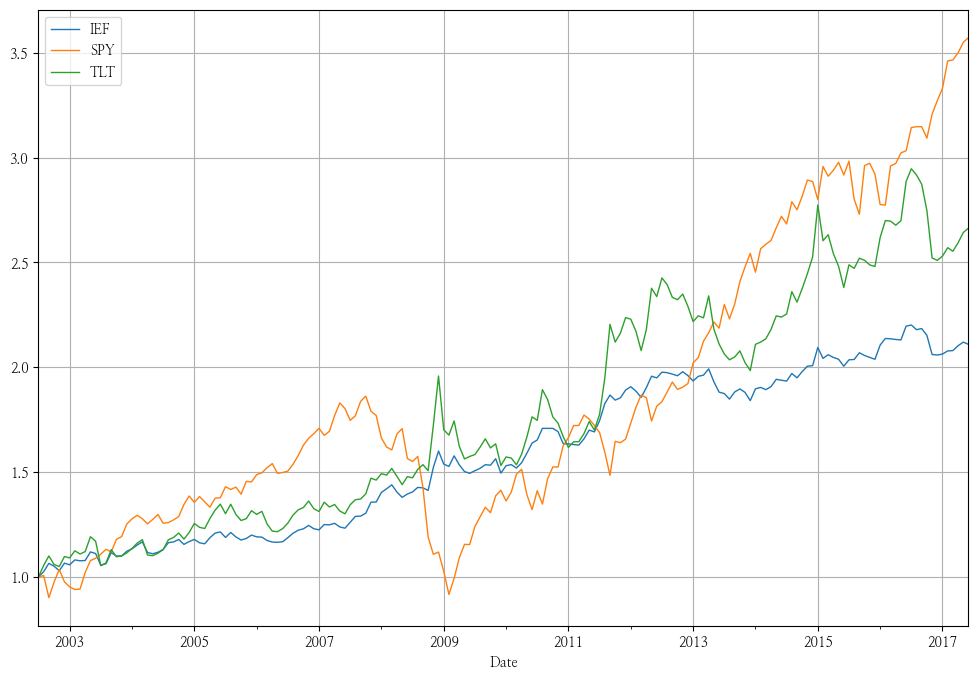

In [7]:
data_m.rebase(1).plot(figsize=(12,8))

In [12]:
data['2003-7'].tail()

,IEF,SPY,TLT
Date,,,
2003-07-25,50.317,69.928,46.367
2003-07-28,49.949,69.670,45.744
2003-07-29,49.462,69.349,45.121
2003-07-30,49.860,69.181,45.630
2003-07-31,49.527,69.342,44.953


In [13]:
s = '2002-07-31'
e = '2017-6-30'
start = '2003-07-31'

In [14]:
score_주식_채권10년 = 평균모멘텀스코어(data_m[['SPY', 'IEF']])
score_주식_채권20년 = 평균모멘텀스코어(data_m[['SPY', 'TLT']])

In [15]:
weights_주식_채권10년 = score_주식_채권10년.div(score_주식_채권10년.sum(axis=1), axis=0)
weights_주식_채권20년 = score_주식_채권20년.div(score_주식_채권20년.sum(axis=1), axis=0)

In [16]:
weights_주식_채권10년.dropna().head()

,SPY,IEF
Date,,
2003-07-31,0.750,0.250
2003-08-31,0.706,0.294
2003-09-30,0.500,0.500
2003-10-31,0.571,0.429
2003-11-30,0.571,0.429


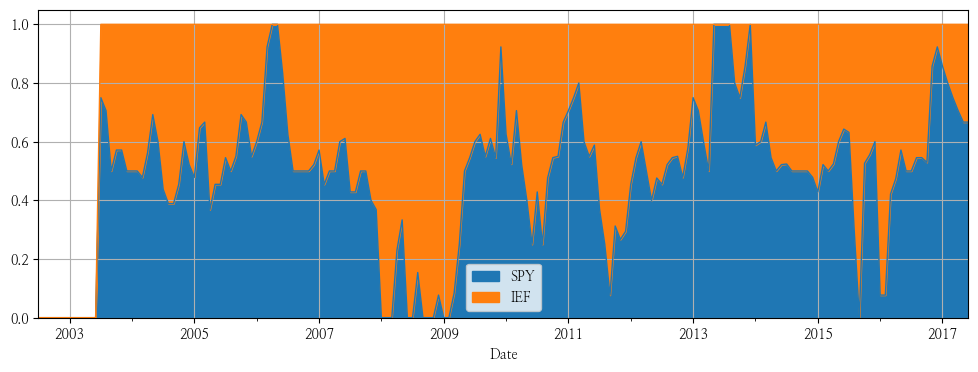

In [17]:
weights_주식_채권10년.plot.area(figsize=(12,4));

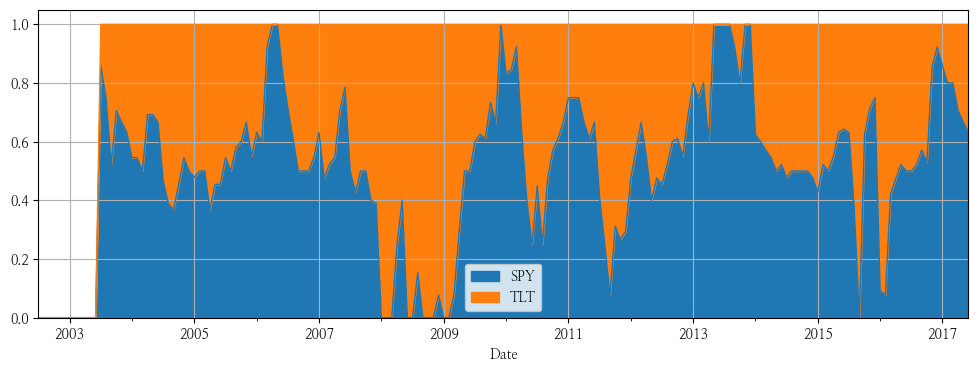

In [19]:
weights_주식_채권20년.plot.area(figsize=(12,4));

In [20]:
def momentumscore(data, weights, name="MomScore", start='1986-1-03'):
    st = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_end_of_period=False), # 월말
            bt.algos.RunAfterDate(start), #1년 뒤부터 시작 : 시작전 12개월 데이터 필요
            bt.algos.SelectAll(),
            bt.algos.WeighTarget(weights),
#             bt.algos.PrintInfo("{now} {temp}"), #{_price} {_universe}
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000.0)

In [21]:
# shift(1)을 하면 전달 기준으로 모멘텀 계산

bt_ms주식채권10년 = momentumscore(data_m[['SPY', 'IEF']], weights_주식_채권10년, '10년국채모멘텀')
bt_ms주식채권20년 = momentumscore(data_m[['SPY', 'TLT']], weights_주식_채권20년, '20년국채모멘텀')

In [22]:
bt_spy = long_only_ew(data_m, ['SPY'], 'SPY')
bt_채권10년 = long_only_ew(data_m, ['IEF'], '채권10년')
bt_채권20년 = long_only_ew(data_m, ['TLT'], '채권20년')

In [23]:
r0 = bt.run(bt_ms주식채권10년,  bt_ms주식채권20년, 
            bt_spy, bt_채권10년, bt_채권20년)

2002-07-31 00:00:00 10년국채모멘텀 
2002-08-31 00:00:00 10년국채모멘텀 
2002-09-30 00:00:00 10년국채모멘텀 
2002-10-31 00:00:00 10년국채모멘텀 
2002-11-30 00:00:00 10년국채모멘텀 
2002-12-31 00:00:00 10년국채모멘텀 
2003-01-31 00:00:00 10년국채모멘텀 
2003-02-28 00:00:00 10년국채모멘텀 
2003-03-31 00:00:00 10년국채모멘텀 
2003-04-30 00:00:00 10년국채모멘텀 
2003-05-31 00:00:00 10년국채모멘텀 
2003-06-30 00:00:00 10년국채모멘텀 
2003-07-31 00:00:00 10년국채모멘텀 SPY:0.750 IEF:0.250 
2003-08-31 00:00:00 10년국채모멘텀 SPY:0.706 IEF:0.294 
2003-09-30 00:00:00 10년국채모멘텀 SPY:0.500 IEF:0.500 
2003-10-31 00:00:00 10년국채모멘텀 SPY:0.571 IEF:0.429 
2003-11-30 00:00:00 10년국채모멘텀 SPY:0.571 IEF:0.429 
2003-12-31 00:00:00 10년국채모멘텀 SPY:0.500 IEF:0.500 
2004-01-31 00:00:00 10년국채모멘텀 SPY:0.500 IEF:0.500 
2004-02-29 00:00:00 10년국채모멘텀 SPY:0.500 IEF:0.500 
2004-03-31 00:00:00 10년국채모멘텀 SPY:0.478 IEF:0.522 
2004-04-30 00:00:00 10년국채모멘텀 SPY:0.562 IEF:0.438 
2004-05-31 00:00:00 10년국채모멘텀 SPY:0.692 IEF:0.308 
2004-06-30 00:00:00 10년국채모멘텀 SPY:0.600 IEF:0.400 
2004-07-31 00:00:00 10년국채모멘텀 SPY:0.438 I

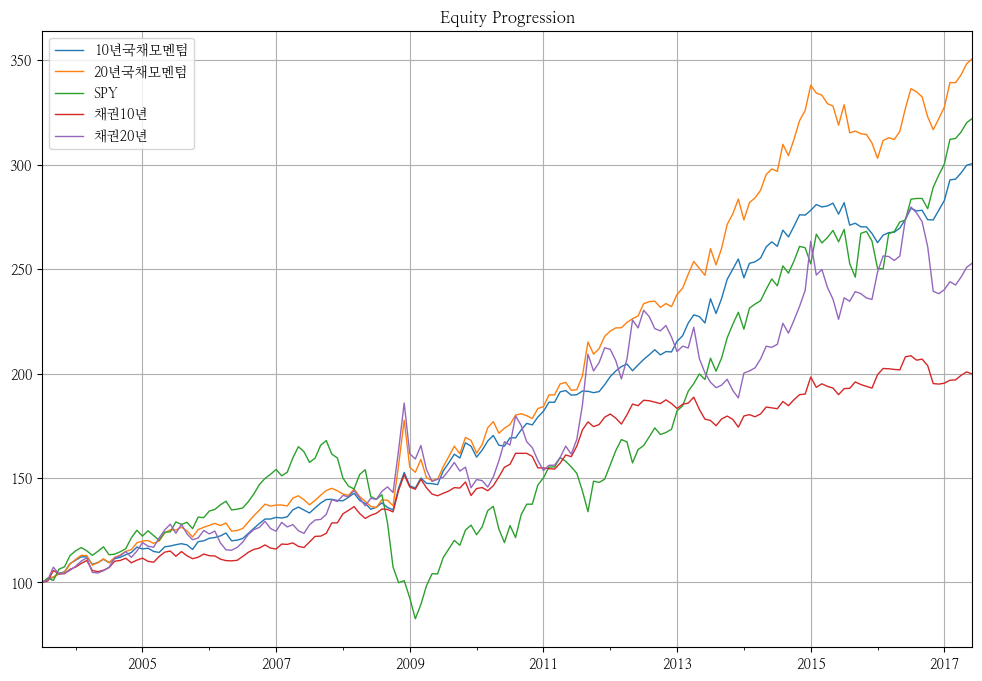

In [24]:
r0.set_date_range(start, e)
r0.plot(figsize=(12,8));

In [25]:
r0.stats

,10년국채모멘텀,20년국채모멘텀,SPY,채권10년,채권20년
start,2003-07-31 00:00:00,2003-07-31 00:00:00,2003-07-31 00:00:00,2003-07-31 00:00:00,2003-07-31 00:00:00
end,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00
rf,0.000,0.000,0.000,0.000,0.000
total_return,2.005,2.507,2.221,0.998,1.528
cagr,0.082,0.094,0.088,0.051,0.069
max_drawdown,-0.068,-0.162,-0.508,-0.076,-0.218
calmar,1.210,0.582,0.173,0.671,0.316
mtd,0.003,0.007,0.006,-0.005,0.008
three_month,0.027,0.034,0.032,0.015,0.036
six_month,0.098,0.107,0.114,0.023,0.056


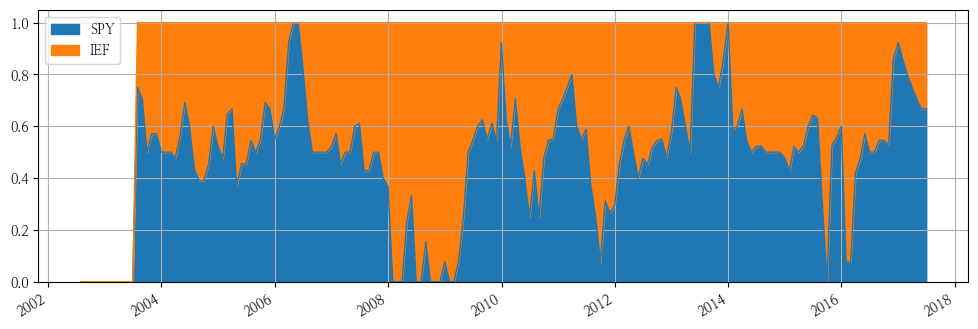

In [26]:
r0.get_security_weights('10년국채모멘텀').plot.area(figsize=(12,4));

In [27]:
r_spy = bt.run(bt_spy)
r_10 = bt.run(bt_ms주식채권10년)
r_20 = bt.run(bt_ms주식채권20년)

## 그림 2.31

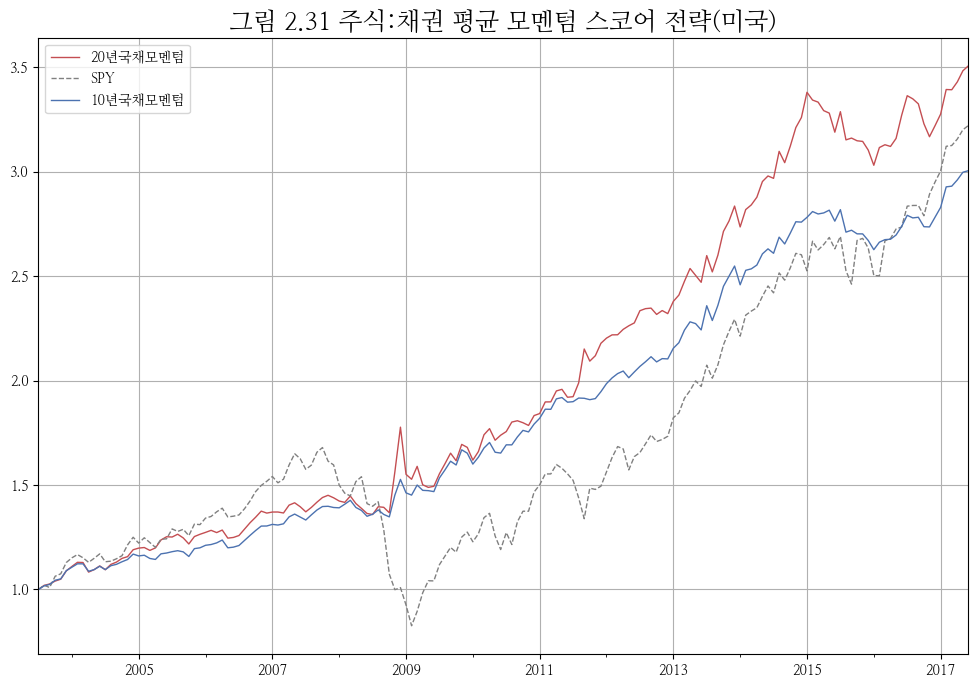

In [50]:
r_20.set_date_range(start,e)
r_spy.set_date_range(start,e)
r_10.set_date_range(start,e)

ax1 = r_20.prices.rebase(1).plot(color='r', figsize=(12,8));
r_spy.prices.rebase(1).plot(ax=ax1, ls='--', color='gray', figsize=(12, 8));
r_10.prices.rebase(1).plot(ax=ax1, ls='-', color='b', figsize=(12, 8));
plt.title("그림 2.31 주식:채권 평균 모멘텀 스코어 전략(미국)", fontsize=18);

In [22]:
# qs.reports.full(r_all.prices['모멘텀 포트폴리오(현금혼합)'].to_returns().dropna()['1986':],
#                 r_all.prices['KOSPI'].to_returns().dropna()['1986':])

# 일일데이터

In [29]:
# 월말에 계산하고 다음월 첫 거래일 종가로 거래 한다고 전재
# 12개월 평균모멘텀스코어 계산

class WeighAMS(bt.Algo):
    def __init__(self, lag, months):
        super(WeighAMS, self).__init__()
        self.lag = lag
        self.months = months

    def 평균모멘텀스코어(self, 데이터, 개월):
        초기값 = 0
        for i in range(1, 개월+1):
            초기값 += np.where(데이터 / 데이터.shift(i) > 1, 1, 0)
        return 초기값[-1]/개월

    def AMS(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        average_momentum_score = pd.Series(dtype='float64')
        # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = (target.now - pd.DateOffset(months=self.lag)).strftime("%Y-%m")
        start = (target.now - pd.DateOffset(months=self.lag) - pd.DateOffset(months=self.months)).strftime("%Y-%m")

        print(f"\nprc : {target.now} {t0} ~ {start}")
        prc = target.universe[selected].loc[start:t0].resample('M').last()
        if (len(prc) < self.months+1):
            return False

        weights = pd.Series(self.AMS(prc), index=selected)
        weights = weights/weights.sum()

        # print(self.평균모멘텀스코어(prc, self.months), prc)
        target.temp['weights'] = weights

        return True

In [30]:
class WeighAMS1(bt.Algo):
    def __init__(self, lag, lookback):
        super(WeighAMS1, self).__init__()
        self.lag = lag
        self.lookback = lookback

    def average_momentum_score(self, t0, prices):
        momentums_score = 0
        for m in range(1, self.lookback+1):
            start = t0 - pd.DateOffset(months=m)
            prc = prices.loc[start:t0]
            momentum_score = np.where(prc.calc_total_return() > 0, 1, 0)
            momentums_score += momentum_score

        return pd.Series(momentums_score / self.lookback, index=prices.columns)

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = target.now - self.lag
        start = t0 - pd.DateOffset(months=self.lookback)
        print(f"{target.now} prc {start} ~ {t0}")
        prc = target.universe.loc[start:t0, selected]
        if len(prc) < 1 or prc.isnull().values.any():
            print(f"{target.now} not yet data")
            return False

        weights = pd.Series(self.average_momentum_score(t0, prc), index=selected)
        weights = weights/weights.sum() 
        
        target.temp['weights'] = weights

        return True

In [31]:
def average_momentum_score_strategy(name, data, tickers, lag=1, months=12):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=True, #월말
                                run_on_last_date=False),
            bt.algos.SelectThese(tickers),
            # WeighAMS(lag, months), # lags=0이면 위와 같다.
            WeighAMS1(lag=pd.DateOffset(months=0), lookback=months),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000)

일간 데이터 : data

In [33]:
bt_daily_12 = average_momentum_score_strategy('10년국채모멘텀1', data_m, 
                                              ['SPY', 'IEF'], lag=0)
r_daily_12 = bt.run(bt_daily_12)

r_00 = bt.run(bt_daily_12, bt_ms주식채권10년)

2002-07-31 00:00:00 prc 2001-07-31 00:00:00 ~ 2002-07-31 00:00:00
2002-07-31 00:00:00 not yet data
2002-08-31 00:00:00 prc 2001-08-31 00:00:00 ~ 2002-08-31 00:00:00
2002-08-31 00:00:00 not yet data
2002-09-30 00:00:00 prc 2001-09-30 00:00:00 ~ 2002-09-30 00:00:00
2002-09-30 00:00:00 not yet data
2002-10-31 00:00:00 prc 2001-10-31 00:00:00 ~ 2002-10-31 00:00:00
2002-10-31 00:00:00 not yet data
2002-11-30 00:00:00 prc 2001-11-30 00:00:00 ~ 2002-11-30 00:00:00
2002-11-30 00:00:00 not yet data
2002-12-31 00:00:00 prc 2001-12-31 00:00:00 ~ 2002-12-31 00:00:00
2002-12-31 00:00:00 not yet data
2003-01-31 00:00:00 prc 2002-01-31 00:00:00 ~ 2003-01-31 00:00:00
2003-01-31 00:00:00 not yet data
2003-02-28 00:00:00 prc 2002-02-28 00:00:00 ~ 2003-02-28 00:00:00
2003-02-28 00:00:00 not yet data
2003-03-31 00:00:00 prc 2002-03-31 00:00:00 ~ 2003-03-31 00:00:00
2003-03-31 00:00:00 not yet data
2003-04-30 00:00:00 prc 2002-04-30 00:00:00 ~ 2003-04-30 00:00:00
2003-04-30 00:00:00 not yet data
2003-05-31

In [34]:
# 처음과 동일함을 검증(로직)
r_00.set_date_range(start)
r_00.display()

Stat                 10년국채모멘텀1    10년국채모멘텀
-------------------  -----------------  ----------------
Start                2003-07-31         2003-07-31
End                  2017-06-30         2017-06-30
Risk-free rate       0.00%              0.00%

Total Return         200.47%            200.47%
Daily Sharpe         -                  -
Daily Sortino        -                  -
CAGR                 8.23%              8.23%
Max Drawdown         -6.80%             -6.80%
Calmar Ratio         1.21               1.21

MTD                  0.26%              0.26%
3m                   2.65%              2.65%
6m                   9.85%              9.85%
YTD                  7.99%              7.99%
1Y                   9.75%              9.75%
3Y (ann.)            4.53%              4.53%
5Y (ann.)            8.04%              8.04%
10Y (ann.)           8.36%              8.36%
Since Incep. (ann.)  8.23%              8.23%

Daily Sharpe         -                  -
Daily Sortino        - 

## 일간 데이터 사용

In [35]:
bt_daily_10 = average_momentum_score_strategy('10년국채모멘텀(일간)', data, 
                                              ['SPY', 'IEF'], lag=0)
bt_daily_20 = average_momentum_score_strategy('20년국채모멘텀(일간)', data, 
                                              ['SPY', 'TLT'], lag=0)

In [36]:
r_daily = bt.run(bt_daily_10, bt_daily_20)

2002-07-30 00:00:00 prc 2001-07-30 00:00:00 ~ 2002-07-30 00:00:00
2002-07-30 00:00:00 not yet data
2002-07-31 00:00:00 prc 2001-07-31 00:00:00 ~ 2002-07-31 00:00:00
2002-07-31 00:00:00 not yet data
2002-08-30 00:00:00 prc 2001-08-30 00:00:00 ~ 2002-08-30 00:00:00
2002-08-30 00:00:00 not yet data
2002-09-30 00:00:00 prc 2001-09-30 00:00:00 ~ 2002-09-30 00:00:00
2002-09-30 00:00:00 not yet data
2002-10-31 00:00:00 prc 2001-10-31 00:00:00 ~ 2002-10-31 00:00:00
2002-10-31 00:00:00 not yet data
2002-11-29 00:00:00 prc 2001-11-29 00:00:00 ~ 2002-11-29 00:00:00
2002-11-29 00:00:00 not yet data
2002-12-31 00:00:00 prc 2001-12-31 00:00:00 ~ 2002-12-31 00:00:00
2002-12-31 00:00:00 not yet data
2003-01-31 00:00:00 prc 2002-01-31 00:00:00 ~ 2003-01-31 00:00:00
2003-01-31 00:00:00 not yet data
2003-02-28 00:00:00 prc 2002-02-28 00:00:00 ~ 2003-02-28 00:00:00
2003-02-28 00:00:00 not yet data
2003-03-31 00:00:00 prc 2002-03-31 00:00:00 ~ 2003-03-31 00:00:00
2003-03-31 00:00:00 not yet data
2003-04-30

In [37]:
r_daily.set_date_range(start,e)
r_daily.stats

,10년국채모멘텀(일간),20년국채모멘텀(일간)
start,2003-07-31 00:00:00,2003-07-31 00:00:00
end,2017-06-30 00:00:00,2017-06-30 00:00:00
rf,0.000,0.000
total_return,2.099,2.601
cagr,0.085,0.096
max_drawdown,-0.080,-0.210
calmar,1.060,0.459
mtd,0.003,0.007
three_month,0.024,0.033
six_month,0.080,0.089


In [38]:
r_daily.prices[s:e].resample('MS').first().to_drawdown_series().describe()

,10년국채모멘텀(일간),20년국채모멘텀(일간)
count,168.000,168.000
mean,-0.008,-0.020
std,0.013,0.030
min,-0.052,-0.145
25%,-0.013,-0.029
50%,0.000,-0.005
75%,0.000,0.000
max,0.000,0.000


In [39]:
변동성역가중 = bt.Strategy('변동성역가중',
    [
        bt.algos.RunAfterDate(start),
        bt.algos.RunMonthly(run_on_end_of_period=True), #매월말
        bt.algos.SelectAll(),
        bt.algos.WeighInvVol(lookback=pd.DateOffset(years=1), lag=pd.DateOffset(days=1)),
        PrintTempWeights(),
        bt.algos.Rebalance()

    ])

In [40]:
bt_invvol10 = bt.Backtest(변동성역가중, data[['SPY', 'IEF']], name='10년국채(변동성역가중)', initial_capital=100000000)
bt_invvol20 = bt.Backtest(변동성역가중, data[['SPY', 'TLT']], name='20년국채(변동성역가중)', initial_capital=100000000)

In [41]:
r_2_30 = bt.run(bt_daily_10, bt_invvol10, bt_daily_20, bt_invvol20)

2003-08-29 00:00:00 변동성역가중 SPY:0.253 IEF:0.747 
2003-09-30 00:00:00 변동성역가중 SPY:0.263 IEF:0.737 
2003-10-31 00:00:00 변동성역가중 SPY:0.292 IEF:0.708 
2003-11-28 00:00:00 변동성역가중 SPY:0.297 IEF:0.703 
2003-12-31 00:00:00 변동성역가중 SPY:0.315 IEF:0.685 
2004-01-30 00:00:00 변동성역가중 SPY:0.327 IEF:0.673 
2004-02-27 00:00:00 변동성역가중 SPY:0.340 IEF:0.660 
2004-03-31 00:00:00 변동성역가중 SPY:0.359 IEF:0.641 
2004-04-30 00:00:00 변동성역가중 SPY:0.380 IEF:0.620 
2004-05-28 00:00:00 변동성역가중 SPY:0.385 IEF:0.615 
2004-06-30 00:00:00 변동성역가중 SPY:0.394 IEF:0.606 
2004-07-30 00:00:00 변동성역가중 SPY:0.394 IEF:0.606 
2004-08-31 00:00:00 변동성역가중 SPY:0.386 IEF:0.614 
2004-09-30 00:00:00 변동성역가중 SPY:0.387 IEF:0.613 
2004-10-29 00:00:00 변동성역가중 SPY:0.376 IEF:0.624 
2004-11-30 00:00:00 변동성역가중 SPY:0.372 IEF:0.628 
2004-12-31 00:00:00 변동성역가중 SPY:0.367 IEF:0.633 
2005-01-31 00:00:00 변동성역가중 SPY:0.356 IEF:0.644 
2005-02-28 00:00:00 변동성역가중 SPY:0.353 IEF:0.647 
2005-03-31 00:00:00 변동성역가중 SPY:0.361 IEF:0.639 
2005-04-29 00:00:00 변동성역가중 SPY:0.343 IEF

In [42]:
r_2_30.set_date_range(start,e)
r_2_30.stats

,10년국채모멘텀(일간),10년국채(변동성역가중),20년국채모멘텀(일간),20년국채(변동성역가중)
start,2003-07-31 00:00:00,2003-07-31 00:00:00,2003-07-31 00:00:00,2003-07-31 00:00:00
end,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00
rf,0.000,0.000,0.000,0.000
total_return,2.099,1.321,2.601,2.059
cagr,0.085,0.062,0.096,0.084
max_drawdown,-0.080,-0.116,-0.210,-0.174
calmar,1.060,0.540,0.459,0.479
mtd,0.003,-0.001,0.007,0.007
three_month,0.024,0.021,0.033,0.036
six_month,0.080,0.046,0.089,0.077


In [51]:
r_2_30.prices[s:e].resample('MS').first().to_drawdown_series().describe()

,10년국채모멘텀(일간),10년국채(변동성역가중),20년국채모멘텀(일간),20년국채(변동성역가중)
count,168.000,168.000,168.000,168.000
mean,-0.008,-0.009,-0.020,-0.019
std,0.013,0.015,0.030,0.030
min,-0.052,-0.090,-0.145,-0.149
25%,-0.013,-0.011,-0.029,-0.030
50%,0.000,-0.001,-0.005,-0.005
75%,0.000,0.000,0.000,0.000
max,0.000,0.000,0.000,0.000


# 그림 2.32

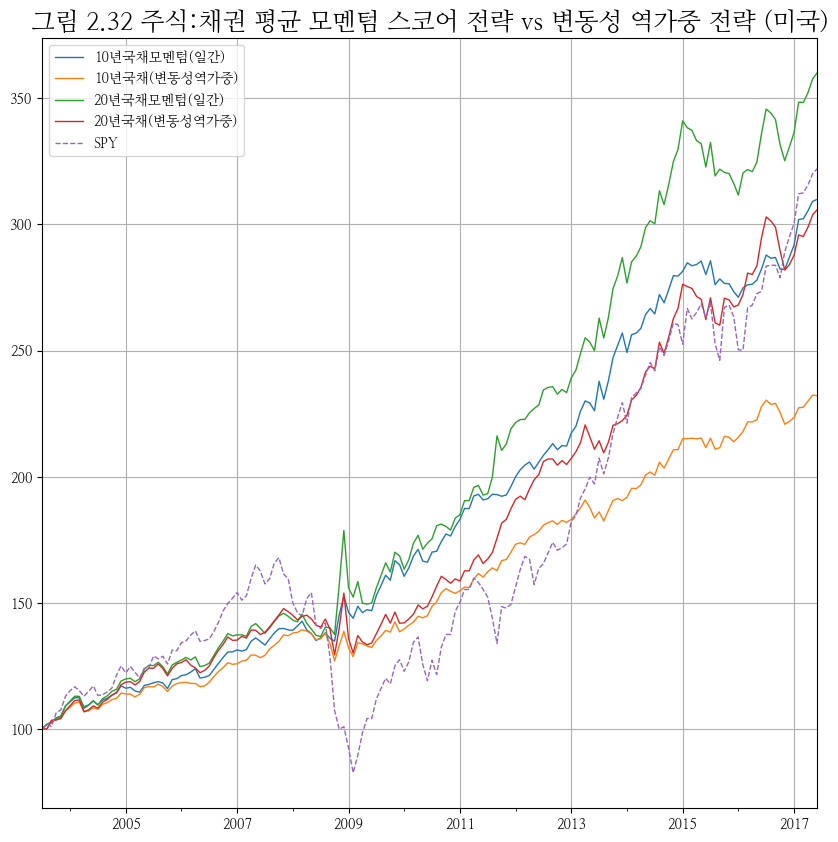

In [43]:
r_spy.set_date_range(start,e)
ax1 = r_2_30.plot(freq='M', figsize=(10,10));
r_spy.plot(ax=ax1, freq='M', ls='--', figsize=(10,10));
plt.title("그림 2.32 주식:채권 평균 모멘텀 스코어 전략 vs 변동성 역가중 전략 (미국)", fontsize=18);

책의 그림과 많이 다른데....성능이 책 만큼 나오지 않았다.

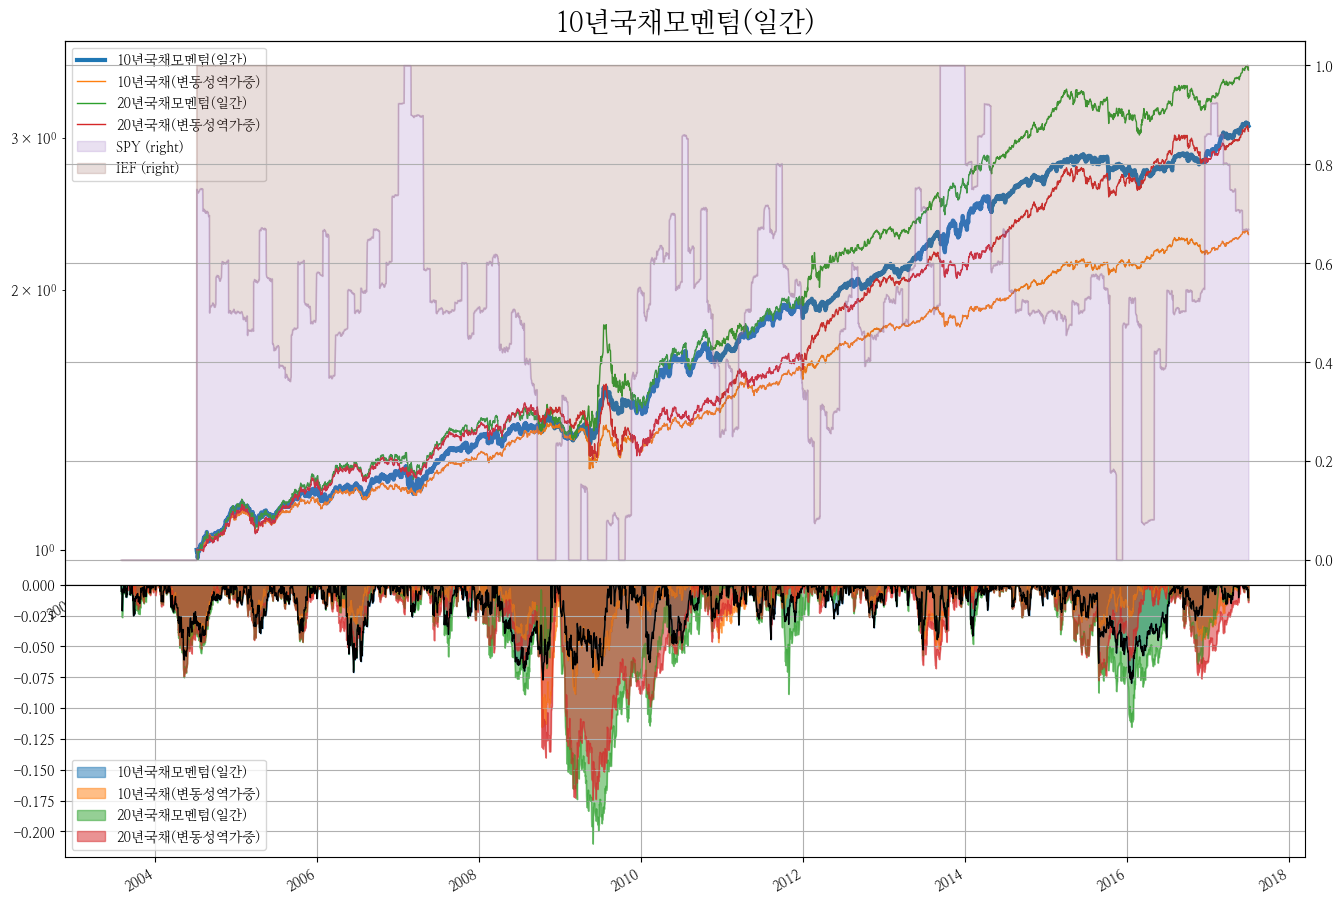

In [44]:
plot_assets(r_2_30, s, e, "10년국채모멘텀(일간)")

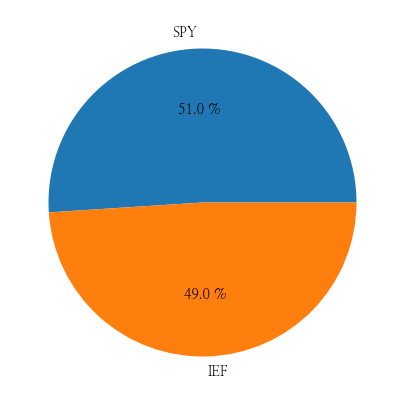

In [45]:
# 10년국채모멘텀(일간)	10년국채(변동성역가중)	20년국채모멘텀(일간)	20년국채(변동성역가중)
r_2_30.get_security_weights('10년국채모멘텀(일간)')[s:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

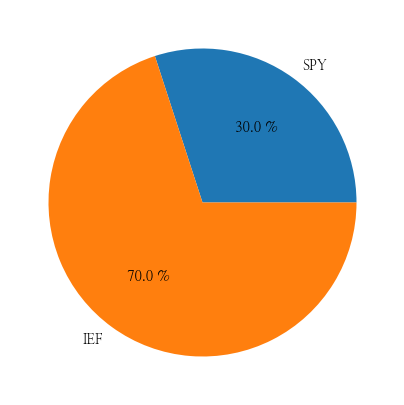

In [46]:
# 10년국채모멘텀(일간)	10년국채(변동성역가중)	20년국채모멘텀(일간)	20년국채(변동성역가중)
r_2_30.get_security_weights('10년국채(변동성역가중)')[s:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

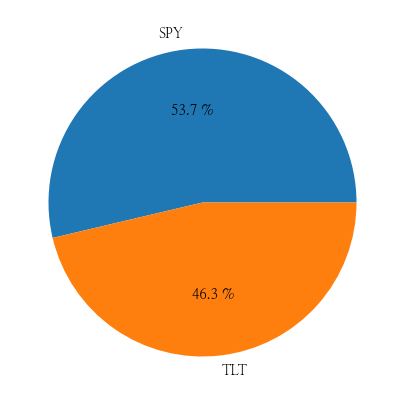

In [47]:
# 10년국채모멘텀(일간)	10년국채(변동성역가중)	20년국채모멘텀(일간)	20년국채(변동성역가중)
r_2_30.get_security_weights('20년국채모멘텀(일간)')[s:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

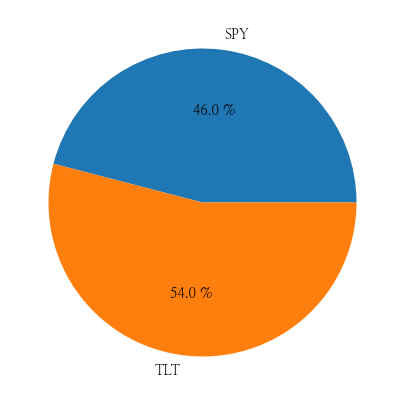

In [48]:
# 10년국채모멘텀(일간)	10년국채(변동성역가중)	20년국채모멘텀(일간)	20년국채(변동성역가중)
r_2_30.get_security_weights('20년국채(변동성역가중)')[s:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));